In [1]:
import serial
import struct
import time
import numpy as np
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.utils import np_utils
from serial.tools.list_ports import comports

debug = True

def read_number(msg):
    return int(input(msg))

def read_port(msg):
    port = input(msg)
    #index = input(msg)
    #port = "COM8";
    return serial.Serial(port, 9600)

            
def print_until_keyword(keyword, device):
    while True: 
        msg = device.serial.readline().decode()
        if msg[:-2] == keyword: break
        #else: print(f'({arduino.port}):',msg, end='')
            
def read_matrix(device, dimms):
    result = np.zeros((1,dimms)).reshape(-1)
    for i in range(dimms):
        device.serial.read()
        result[i] = struct.unpack('f', device.serial.read(4))[0]
    
    return result.reshape(dimms)

clear = lambda: os.system('clear')

2023-11-18 19:33:01.264268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-18 19:33:01.264290: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
class Device:
    def __init__(self, serial):
        self.serial = serial
        self.weights = []
        self.metalayers = []
        self.gradients = []
        
    def set_weights(self, weights):
        self.weights = weight
        
    def set_metadata(self, metalayer):
        self.metalayer = metalayer
        
def getDevices():
    #num_devices = read_number("Number of devices: ")
    # num_devices = 2
    num_devices=3

    available_ports = comports()
    print("Available ports:")
    for available_port in available_ports: print(available_port)

    global name_ports 
    name_ports = []
        
    for available_port in available_ports:
        input_pattern = str(available_port)
        first_value = input_pattern.split('-')[0].strip()
        name_ports.append(first_value)

    devices = [serial.Serial(port, 9600) for port in  name_ports]
            
    time.sleep(1)
    #devices = [read_port(f"Port device_{i+1}: ") for i in range(num_devices)]
    #devices= [serial.Serial(port, 9600) for port in ['/dev/cu.usbmodem14101', '/dev/cu.usbmodem14201','/dev/cu.usbmodem14301']]
    list_devices = []
    for device in devices:
        list_devices.append(Device(device))
    return list_devices

class Layer:
    def __init__(self, layer_type):
        self.layer_type = layer_type
        
    def __repr__(self):
        return f"{self.layer_type}"
    
class Dense(Layer):
    def __init__(self, rows, cols):
        super().__init__("Dense")
        self.rows = rows
        self.cols = cols
        
    def __repr__(self):
        return f"{self.layer_type=} {self.rows=} {self.cols=}"
    
class MaxPooling(Layer):
    def __init__(self, r, c, ch):
        super().__init__("MaxPooling")
        self.rows = r
        self.cols = c
        self.ch = ch
        
    def __repr__(self):
        return f"{self.layer_type}  - {self.rows=} {self.cols=} {self.ch=}"
    
class Conv2D(Layer):
    def __init__(self, kh, kw, c, kc):
        super().__init__("Conv2D")
        self.kh = kh
        self.kw = kw
        self.c = c
        self.kc = kc
        
    def __repr__(self):
        return f"{self.layer_type=} - {self.kh=} {self.kw=} {self.c=} {self.kc=}"
        

In [3]:
def receive_model_info(device):
    device.serial.reset_input_buffer()
    device.serial.write(b's')
    print_until_keyword('start', device) # CLEAN SERIAL
    
    bytesToRead = device.serial.read(1).decode()
    time.sleep(1)
    if bytesToRead == 'i':
        device.serial.write(struct.pack('f', LEARNING_RATE))
        [num_layers] = struct.unpack('i', device.serial.read(4))
        layers = []
        for i in range(num_layers):
            [layer_type] = struct.unpack('i', device.serial.read(4))
            if layer_type == -1:
                [rows, cols] = struct.unpack('ii', device.serial.read(8))
                layers.append(Dense(rows, cols))
            elif layer_type == -2:
                [rows, cols, ch] = struct.unpack('iii', device.serial.read(12))
                layers.append(MaxPooling(rows,cols,ch))
            elif layer_type == -3:
                [kh, kw, c, kc] = struct.unpack('iiii', device.serial.read(16))
                layers.append(Conv2D(kh,kw,c,kc))
            # dimms.append((1,cols)) # bias
            # dimms.append((rows,cols)) # matrix weigths
        device.metalayers = layers
    return num_layers, layers


In [4]:
import random    
## RECEIVE MODEL WEIGHT
def get_device_weights(device, bias_dimm, w_dimm):
    number_of_floats = w_dimm[0] * w_dimm[1]
    weights = np.zeros(w_dimm).reshape(-1)
    for i in range(number_of_floats):
        device.serial.read()
        weights[i] = struct.unpack('f', device.serial.read(4))[0]
        
    number_of_floats = bias_dimm[0] * bias_dimm[1]
    bias = np.zeros(bias_dimm).reshape(-1)
    for i in range(number_of_floats):
        device.serial.read()
        bias[i] = struct.unpack('f', device.serial.read(4))[0]
    
    return weights.reshape(w_dimm), bias.reshape(bias_dimm)
    
def get_device_weights_cnn(device, kh, kw, c, kc):
    in_size = kh * kw * c
    out_size = kh * kw * kc
    weights = np.zeros((kh, kw, c, kc)).reshape(-1)
    for i,w in enumerate(weights.reshape(-1)):
        device.serial.read()
        weights[i] = struct.unpack('f', device.serial.read(4))[0]
            
    bias = np.zeros((1,kc)).reshape(-1)
    for i,b in enumerate(bias.reshape(-1)):
        device.serial.read()
        bias[i] = struct.unpack('f', device.serial.read(4))[0]
    
    return weights.reshape((kh, kw, c, kc)), bias.reshape((1,kc))

def get_device_weights_pool(device, rows, cols, ch):
    weights = np.random.randn(rows, cols, ch).reshape(-1)
    for i,w in enumerate(weights.reshape(-1)):
        device.serial.read()
        weights[i] = struct.unpack('f', device.serial.read(4))[0]
    
    return weights.reshape((rows, cols, ch))
    

In [5]:
def initialize_device_weights(device, bias_dimm, w_dimm):
    np.random.seed(42)
    random.seed(42)
    bias = np.zeros(bias_dimm)
    weights = np.random.randn(w_dimm[0], w_dimm[1]) * np.sqrt(6.0 / (w_dimm[0] + w_dimm[1]))
    return weights, bias
    device.serial.write(struct.pack('f'*bias.reshape(-1).shape[0], *bias.reshape(-1)))

    #for w in weights.reshape(-1):
    #   data = device.serial.read()
    device.serial.write(struct.pack('f'*weights.reshape(-1).shape[0], *weights.reshape(-1)))
    
def initialize_device_weights_cnn(device, kh, kw, c, kc):
    np.random.seed(42)
    random.seed(42)
    bias = np.zeros((1,kc))
    in_size = kh * kw * c
    out_size = kh * kw * kc
    weights = np.random.randn(kh, kw, c, kc) * np.sqrt(6.0 / (in_size + out_size))
    return weights, bias
    print(f"Sending weights for layer Conv2D")
    #for b in bias.reshape(-1):
        #data = device.serial.read()
    device.serial.write(struct.pack('f'* bias.reshape(-1).shape[0], *bias.reshape(-1)))

    #for w in weights.reshape(-1):
    #   data = device.serial.read()
    device.serial.write(struct.pack('f' * weights.reshape(-1).shape[0], *weights.reshape(-1)))

def create_initial_model(device, layers):
    weights = []
    for layer in layers:
        if layer.layer_type == "Conv2D":
            weights.append(initialize_device_weights_cnn(device, layer.kh, layer.kw, layer.c, layer.kc))
        elif layer.layer_type == "Dense":
            weights.append(initialize_device_weights(device, (1,layer.cols), (layer.rows,layer.cols)))
        else:
            weights.append((np.array([]), np.array([])))
    return weights

    
def send_initial_weights(device, global_model):
    for weights, bias in global_model:
        #print(weights.shape, bias.shape)
        device.serial.write(struct.pack('f' * bias.reshape(-1).shape[0], *bias.reshape(-1)))
        device.serial.write(struct.pack('f' * weights.reshape(-1).shape[0], *weights.reshape(-1)))
    

In [6]:
def send_weights(device, weights, layer):
    bias = weights[1]
    weights = weights[0]
    #print(f"Sending bias for Dense {bias.reshape(-1).shape} {device.serial.port}")
    #for b in bias.reshape(-1):
        #data = device.serial.read()
        #device.serial.write(struct.pack('f', b))
    if layer.layer_type != 'MaxPooling':
        device.serial.write(struct.pack('f' * bias.reshape(-1).shape[0],*bias.reshape(-1)))
        device.serial.write(struct.pack('f' * weights.reshape(-1).shape[0], *weights.reshape(-1)))

    #print(f"Sending weights for Dense {weights.reshape(-1).shape} {device.serial.port}")
    #for w in weights.reshape(-1):
        #data = device.serial.read()
        
def send_model_weights(device, weights):
    layers = device.metalayers
    device.serial.write(b'r')
 
    for i, layer in enumerate(weights):
        send_weights(device, weights[i], layers[i])

    #print(f"{device.serial.port} weights initialized!")

In [7]:
def get_model_weights(device):
    layers = device.metalayers
    device.serial.write(b'g') # Python --> ACK --> Arduino
    device.weights = []

    for i, layer in enumerate(layers):
        if layer.layer_type == "Conv2D":
            weights, biases = get_device_weights_cnn(device, layer.kh, layer.kw, layer.c, layer.kc)
            device.weights.append((weights, biases))
        elif layer.layer_type == "Dense":
            weights, biases = get_device_weights(device, (1,layer.cols), (layer.rows,layer.cols))
            device.weights.append((weights, biases))
        elif layer.layer_type == "MaxPooling":
            #weights = get_device_weights_pool(device, layer.rows,layer.cols, layer.ch)
            device.weights.append((weights, np.array([])))
    #print(f"Model weight received!")

    
def get_model_gradients(device):
    layers = device.metalayers
    device.serial.write(b'g') # Python --> ACK --> Arduino
    device.gradients = []
    
    for i, layer in enumerate(layers):
        if layer.layer_type == "Conv2D":
            weights, biases = get_device_weights_cnn(device, layer.kh, layer.kw, layer.c, layer.kc)
            device.gradients.append((weights, biases))
        elif layer.layer_type == "Dense":
            weights, biases = get_device_weights(device, (1,layer.cols), (layer.rows,layer.cols))
            device.gradients.append((weights, biases))
        elif layer.layer_type == "MaxPooling":
            #weights = get_device_weights_pool(device, layer.rows,layer.cols, layer.ch)
            device.gradients.append((np.array([]), np.array([])))
    #print(f"Model weight received!")


In [8]:
def send_sample(device, X, y=None):
    #if IS_KEYWORD_SPOTTING:
        #for i,k in enumerate(X.reshape(-1)):
            #device.serial.write(struct.pack('f',k))
            #print("SENT XX",i)
        #device.serial.write(struct.pack('h' * X.reshape(-1).shape[0], *X.reshape(-1)))
    #else:
    device.serial.write(struct.pack('f' * X.reshape(-1).shape[0], *X.reshape(-1)))

        #for i,k in enumerate(X.reshape(-1)):
            #raw = device.serial.read(4)
            #j = struct.unpack('i', raw)[0]
            #device.serial.write(struct.pack('f',k))
            #print("SENT",j, i)
            #print(f"returned error = {raw}")

    #print(f"Want to send y={y.shape}")
    if y is not None:
        device.serial.write(struct.pack('f' * y.reshape(-1).shape[0], *y.reshape(-1)))
        #for i, t in enumerate(y.reshape(-1)):
            #device.serial.read()
            #device.serial.write(struct.pack('f', t))
        #print(f"Sample y = {y.shape} sent!")

def get_tick():
    return time.time_ns()

def train_single(device, x, y, train_data):
    device.serial.write(b"t")
    send_sample(device, x, y.reshape(1,TARGET_SIZE))
    start = get_tick()
    output = read_matrix(device, TARGET_SIZE+1)
    end = get_tick()
    train_data['losses'][device.serial.port] = output[-1]
    train_data['times'][device.serial.port] = end-start
    res = output[:-1]
    train_data['acc'][device.serial.port] = 1 if np.argmax(y) == np.argmax(res) else 0


def train(device, X, y, size=1):
    error = 0.0
    for i in range(size):
        if i%100 == 0:
            print(f"{i}/{size} Done")
        device.serial.write(b"t")
        send_sample(device, X[i], y[i].reshape(1,TARGET_SIZE))
        #print("SAMPLE SENT")

        start = get_tick()
        output = read_matrix(device, TARGET_SIZE+1)
        #n_error = device.serial.read(4)
        #print(f"returned error = {n_error}")
        end = get_tick()
        loss = struct.unpack('f', n_error)[0]
        error += loss
    return end-start, error/size

def predict(device, X, y):
    device.serial.write(b"p")
    send_sample(device, X, y.reshape(1,TARGET_SIZE))
    # read last layer size output
    # Target size + 1 for the loss value
    start = get_tick()
    output = read_matrix(device, TARGET_SIZE+1)
    return get_tick() - start, output[:-1], output[-1]


- call getDevices() to obtain all conected devices
- asks the user how many devices you want to use
- send the initial model for every device
- create thread for every device
    - send samples and start training for one epoch
- wait for all threads to finish
- FEDERATED LEARNING
- create thread for every device and receive models
- permute the average of every layer
- create thread for every device and receive models
- send back the models

In [9]:
final_weights = []
def fl(devices):
    global final_weights
    
    # RECEIVE MODELS
    print("Receiving models from devices...")
    threads = []
    for device in devices:
        thread = threading.Thread(target=get_model_weights, args=(device,))
        thread.daemon = True
        thread.start()
        threads.append(thread)

    for thread in threads: thread.join() # Wait for all the threads to end
    print("Models received")
    # AVERAGE MODELS
    num_layers = len(devices[0].metalayers)
    assert num_layers > 0, "NO LAYERS!"

    #accuracies = fl_info_infer[-2]['accuracy']
    #total_accuracy = sum(accuracies.values())
    #normalized_accuracies = [accuracy / total_accuracy for accuracy in accuracies.values()]
    #print(normalized_accuracies)
    list_weights = []
    for i in range(num_layers):
        weights = np.array([device.weights[i][0] for device in devices])
        bias = np.array([device.weights[i][1] for device in devices])

        weights_avg = np.mean(weights, axis=0)
        bias_avg = np.mean(bias, axis=0)

        list_weights.append((weights_avg, bias_avg))
    print("Average performed")
    # send model
    threads = []
    for device in devices:
        thread = threading.Thread(target=send_model_weights, args=(device, list_weights))
        thread.daemon = True
        thread.start()
        threads.append(thread)
    for thread in threads: thread.join() # Wait for all the threads to end
        
    final_weights = list_weights

In [10]:
def fl_sgd(devices):
    # RECEIVE MODELS
    threads = []
    for device in devices:
        thread = threading.Thread(target=get_model_gradients, args=(device,))
        thread.daemon = True
        thread.start()
        threads.append(thread)

    for thread in threads: thread.join() # Wait for all the threads to end
    #print("Models received")
    # AVERAGE MODELS
    num_layers = len(devices[0].metalayers)
    assert num_layers > 0, "NO LAYERS!"
    
    # GET GRADIENTS OF THE DEVICES
    list_weights = []
    for i in range(num_layers):
        gradients_w, gradients_b = devices[0].gradients[i]
        gradients_w = np.zeros_like(gradients_w)
        gradients_b = np.zeros_like(gradients_b)
        for k,device in enumerate(devices):
            #print(device.gradients[i][0])
            #print(device.gradients[i][1])
            gradients_w += device.gradients[i][0]
            gradients_b += device.gradients[i][1]
        
        list_weights.append((gradients_w,gradients_b))

    # SGD HERE
    for i, layer in enumerate(devices[0].metalayers):
        print("FF",list_weights[i][0], list_weights[i][1])
        if layer.layer_type == "MaxPooling":
            continue
        dw = iglobal_model[i][0] - list_weights[i][0] * 0.01
        db = iglobal_model[i][1] - list_weights[i][1] * 0.01
        
        iglobal_model[i] = (dw, db)
    
    
    # send model
    threads = []
    for device in devices:
        thread = threading.Thread(target=send_model_weights, args=(device, iglobal_model))
        thread.daemon = True
        thread.start()
        threads.append(thread)
    for thread in threads: thread.join() # Wait for all the threads to end



In [11]:
def train_device(device, X_train, Y_train,  info, steps = 1):
    device_losses = []
    device_times = []
    if not isinstance(X_train, np.ndarray):
        X_train = np.array(X_train)
    
    if not isinstance(Y_train, np.ndarray):
        Y_train = np.array(Y_train)
    
    dt, loss = train(device, np.array(X_train).astype(np.int16), Y_train, steps)
    device_losses.append(loss)
    device_times.append(dt)
        
    info['losses'][device.serial.port] = device_losses
    info['train_time'][device.serial.port] = device_times

In [12]:
def predict_device(device, X, Y_test, info):
    device_times = []
    
    if not isinstance(X, np.ndarray):
        X = np.array(X)
        print("pre_dev np_array done")
    
    acc = 0.0
    total_loss = 0.0
    df_time = 0
    for i, x in enumerate(X):
        if i%100 == 0:
            print(f"{device.serial.port} => [{i}/{X.shape[0]}] Done")
        
        dt, res, loss = predict(device, x, Y_test[i])
        acc += 1 if np.argmax(Y_test[i]) == np.argmax(res) else 0
        df_time += dt
        total_loss += loss
    info['accuracy'][device.serial.port] = acc/X.shape[0] 
    info['infer_time'][device.serial.port] = df_time / X.shape[0] 
    info['losses'][device.serial.port] = total_loss/X.shape[0]
    #info['res'][device.serial.port] = res 


In [13]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import json

def get_anomaly():
    np.random.seed(42)
    random.seed(42)
    # Read the JSON file
    with open("datasets_2/stateMonitors.json", "r") as file:
        data = json.load(file)

    # Normalize the JSON data
    df = pd.json_normalize(data, max_level=20)
    df['anomaly'] = 0

    # Specify the size of the random subset
    subset_size = 5 #200  # Replace with the desired subset size

    # Get a random subset of the DataFrame
    random_subset = df.sample(n=subset_size, random_state=42)  # Replace '42' with your desired random seed

    cols_to_rand = ['payload.messageSize','payload.state.QR','payload.state.QS','payload.state.QRU','payload.state.QWRP','payload.state.RT','payload.state.packetHeader.Size']
    for col in cols_to_rand:
        random_subset[col] += np.random.randint(2000)

    random_subset['anomaly'] = 1
    
    return df, random_subset

In [14]:
def reset_device(device):
    device.serial.write(b'f')

In [15]:
import threading
import time
devices = []
LEARNING_RATE = 0.001
TARGET_SIZE = 10
IS_KEYWORD_SPOTTING = False
def initialize_devices(lr = 0.001, target_size = 10, first=True):
    global devices
    global LEARNING_RATE
    global TARGET_SIZE
    
    TARGET_SIZE = target_size
    LEARNING_RATE = lr
    if first:
        devices = getDevices()
    else:
        threads = []
        for device in devices:
            print(f"RESETING DEVICE {device.serial.port}")
            thread = threading.Thread(target=reset_device, args=(device, ))
            thread.daemon = True
            threads.append(thread)

          # Start all the threads
        for thread in threads:
            thread.start()

        # Wait for all the threads to finish
        for thread in threads:
            thread.join()
        
    number_devices = 3
    
    time.sleep(3)
    
    threads = []
    for i, d in enumerate(devices):
        print(f"Receiving model info {i}")
        thread = threading.Thread(target=receive_model_info, args=(d, ))
        thread.daemon = True
        threads.append(thread)

      # Start all the threads
    for thread in threads:
        thread.start()

    # Wait for all the threads to finish
    for thread in threads:
        thread.join()

    iglobal_model = create_initial_model(devices[0], devices[0].metalayers)

    threads = []
    for i, d in enumerate(devices):
        print(f"Sending blank model for device {i}")
        thread = threading.Thread(target=send_initial_weights, args=(d, iglobal_model ))
        thread.daemon = True
        threads.append(thread)

      # Start all the threads
    for thread in threads:
        thread.start()

    # Wait for all the threads to finish
    for thread in threads:
        thread.join()
    print("All devices were initialized!")

## Anomaly Detection FL training

In [16]:
threshold = 0.01
X, anomalies = get_anomaly()
y = X['anomaly']
df = X.drop(['date','anomaly'], axis=1)
y_anomalies = anomalies['anomaly']
anomalies = anomalies.drop(['date','anomaly'], axis=1)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Create a StandardScaler object
scaler = MinMaxScaler()

# Apply z-score normalization to the DataFrame
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
# Create a StandardScaler object
scaler2 = MinMaxScaler()

# Fit the scaler on the training data
scaler2.fit(df)

# Apply the same normalization to the test data
df_test_normalized = pd.DataFrame(scaler2.transform(anomalies), columns=anomalies.columns)
df_test_normalized.head()

df_test_normalized = pd.concat([df_normalized, df_test_normalized])
df_test_normalized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310 entries, 0 to 4
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   payload.appPortDst                2310 non-null   float64
 1   payload.appPortSrc                2310 non-null   float64
 2   payload.messageId                 2310 non-null   float64
 3   payload.addrSrc                   2310 non-null   float64
 4   payload.addrDst                   2310 non-null   float64
 5   payload.messageSize               2310 non-null   float64
 6   payload.simCommand                2310 non-null   float64
 7   payload.state.Id                  2310 non-null   float64
 8   payload.state.Type                2310 non-null   float64
 9   payload.state.QR                  2310 non-null   float64
 10  payload.state.QS                  2310 non-null   float64
 11  payload.state.QRU                 2310 non-null   float64
 12  payload.s

In [17]:
import pickle 
def train_ae_with_fl(df, num_devices=3, fl_samples=5, lr=0.001, first=True, iid=True):
    initialize_devices(lr=lr, target_size=25, first=first)
    fl_rounds = 0
    
    X_Train = []
    total_entries = 2305
    each_split_size = total_entries // 3

    X_Train.append(df_normalized.values[0:each_split_size])
    X_Train.append(df_normalized.values[each_split_size:each_split_size*2])
    X_Train.append(df_normalized.values[each_split_size*2:each_split_size*3])

    training_data = []
    
    #total_acc = {'/dev/cu.usbmodem13201':0, '/dev/cu.usbmodem13101':0, '/dev/cu.usbmodem13301':0}
    total_acc = {}
    for d in name_ports:
       #if debug: print("d is ", d)
       total_acc[d] = 0    
    #if debug: print("total_acc = ", total_acc)
    
    for i in range(each_split_size):
        if i%fl_samples==0 and i>0:
            fl(devices)
            fl_rounds += 1
        train_data = {'losses':{}, 'times':{}, 'acc':{}}
        threads = []
        for j, device in enumerate(devices):
            #print("in train_ae_with_fl(): i = ", i)
            #print("in train_ae_with_fl(): j = ", j)
            #print("in train_ae_with_fl(): X_Train[j][i] = ", X_Train[j][i])
            thread = threading.Thread(target=train_single, args=(device, X_Train[j][i],X_Train[j][i], train_data))
            thread.daemon = True
            thread.start()
            threads.append(thread)
        for thread in threads: thread.join() # Wait for all the threads to end
        training_data.append(train_data)
        print(f"Loss: {train_data['losses']} {i}/{each_split_size}")

    # SET THE DEVICES WEIGHT AS THE GLOBAL MODEL
    fl(devices)
    return training_data

In [18]:
loaded_dict = train_ae_with_fl(df,num_devices=3, fl_samples=25, lr=0.01, first=True, iid=True)

Available ports:
/dev/ttyACM3 - Envie M7
/dev/ttyACM2 - Envie M7
/dev/ttyACM1 - Envie M7
Receiving model info 0
Receiving model info 1
Receiving model info 2
Sending blank model for device 0
Sending blank model for device 1
Sending blank model for device 2
All devices were initialized!
Loss: {'/dev/ttyACM3': 0.5459439158439636, '/dev/ttyACM2': 0.5078995227813721, '/dev/ttyACM1': 0.4954840838909149} 0/768
Loss: {'/dev/ttyACM3': 0.546226978302002, '/dev/ttyACM1': 0.486730694770813, '/dev/ttyACM2': 0.487308144569397} 1/768
Loss: {'/dev/ttyACM3': 0.6005211472511292, '/dev/ttyACM2': 0.43734779953956604, '/dev/ttyACM1': 0.3937678039073944} 2/768
Loss: {'/dev/ttyACM3': 0.5452859401702881, '/dev/ttyACM1': 0.3956254720687866, '/dev/ttyACM2': 0.5488247871398926} 3/768
Loss: {'/dev/ttyACM3': 0.5076557397842407, '/dev/ttyACM1': 0.36621132493019104, '/dev/ttyACM2': 0.4588993191719055} 4/768
Loss: {'/dev/ttyACM3': 0.4467228353023529, '/dev/ttyACM2': 0.4098912179470062, '/dev/ttyACM1': 0.664448916912

Models received
Average performed
Loss: {'/dev/ttyACM2': 0.06246676295995712, '/dev/ttyACM3': 0.08239292353391647, '/dev/ttyACM1': 0.10111944377422333} 75/768
Loss: {'/dev/ttyACM1': 0.11253765225410461, '/dev/ttyACM3': 0.08507298678159714, '/dev/ttyACM2': 0.22000464797019958} 76/768
Loss: {'/dev/ttyACM3': 0.04915303364396095, '/dev/ttyACM2': 0.06068594381213188, '/dev/ttyACM1': 0.07723024487495422} 77/768
Loss: {'/dev/ttyACM3': 0.11435379832983017, '/dev/ttyACM2': 0.04639671742916107, '/dev/ttyACM1': 0.1654863804578781} 78/768
Loss: {'/dev/ttyACM3': 0.042304638773202896, '/dev/ttyACM1': 0.0929224044084549, '/dev/ttyACM2': 0.04185032472014427} 79/768
Loss: {'/dev/ttyACM2': 0.03950149938464165, '/dev/ttyACM1': 0.06444140523672104, '/dev/ttyACM3': 0.1798020899295807} 80/768
Loss: {'/dev/ttyACM1': 0.059085968881845474, '/dev/ttyACM2': 0.03528789058327675, '/dev/ttyACM3': 0.04880959913134575} 81/768
Loss: {'/dev/ttyACM3': 0.054103218019008636, '/dev/ttyACM1': 0.046342115849256516, '/dev/tty

Models received
Average performed
Loss: {'/dev/ttyACM2': 0.08310098946094513, '/dev/ttyACM3': 0.02154424972832203, '/dev/ttyACM1': 0.09079140424728394} 150/768
Loss: {'/dev/ttyACM3': 0.02535906247794628, '/dev/ttyACM1': 0.04407436400651932, '/dev/ttyACM2': 0.0898105725646019} 151/768
Loss: {'/dev/ttyACM3': 0.030902264639735222, '/dev/ttyACM2': 0.08031898736953735, '/dev/ttyACM1': 0.08411039412021637} 152/768
Loss: {'/dev/ttyACM3': 0.03347820043563843, '/dev/ttyACM2': 0.08945903927087784, '/dev/ttyACM1': 0.03933611884713173} 153/768
Loss: {'/dev/ttyACM3': 0.01679486222565174, '/dev/ttyACM1': 0.07618162781000137, '/dev/ttyACM2': 0.06282955408096313} 154/768
Loss: {'/dev/ttyACM3': 0.03040781058371067, '/dev/ttyACM2': 0.0884479358792305, '/dev/ttyACM1': 0.05329499393701553} 155/768
Loss: {'/dev/ttyACM3': 0.014366171322762966, '/dev/ttyACM2': 0.06984473019838333, '/dev/ttyACM1': 0.033772677183151245} 156/768
Loss: {'/dev/ttyACM2': 0.044458385556936264, '/dev/ttyACM1': 0.09475551545619965, '

Models received
Average performed
Loss: {'/dev/ttyACM3': 0.051655884832143784, '/dev/ttyACM2': 0.07172907888889313, '/dev/ttyACM1': 0.028560696169734} 225/768
Loss: {'/dev/ttyACM3': 0.07618680596351624, '/dev/ttyACM2': 0.10942216962575912, '/dev/ttyACM1': 0.058448079973459244} 226/768
Loss: {'/dev/ttyACM3': 0.04743751138448715, '/dev/ttyACM2': 0.04718400910496712, '/dev/ttyACM1': 0.040214765816926956} 227/768
Loss: {'/dev/ttyACM3': 0.06436200439929962, '/dev/ttyACM2': 0.028570106253027916, '/dev/ttyACM1': 0.01239748951047659} 228/768
Loss: {'/dev/ttyACM1': 0.02653343603014946, '/dev/ttyACM3': 0.03318855166435242, '/dev/ttyACM2': 0.04036479815840721} 229/768
Loss: {'/dev/ttyACM3': 0.03171246871352196, '/dev/ttyACM2': 0.017753541469573975, '/dev/ttyACM1': 0.011442777700722218} 230/768
Loss: {'/dev/ttyACM3': 0.050498366355895996, '/dev/ttyACM2': 0.03507028892636299, '/dev/ttyACM1': 0.03349649906158447} 231/768
Loss: {'/dev/ttyACM3': 0.048059869557619095, '/dev/ttyACM1': 0.0120822330936789

Models received
Average performed
Loss: {'/dev/ttyACM3': 0.059726063162088394, '/dev/ttyACM2': 0.04778261482715607, '/dev/ttyACM1': 0.051517974585294724} 300/768
Loss: {'/dev/ttyACM3': 0.014438393525779247, '/dev/ttyACM2': 0.037725385278463364, '/dev/ttyACM1': 0.04761122539639473} 301/768
Loss: {'/dev/ttyACM1': 0.03298190236091614, '/dev/ttyACM3': 0.027020644396543503, '/dev/ttyACM2': 0.05807654932141304} 302/768
Loss: {'/dev/ttyACM2': 0.038086675107479095, '/dev/ttyACM1': 0.04415425285696983, '/dev/ttyACM3': 0.0313393659889698} 303/768
Loss: {'/dev/ttyACM3': 0.04992493987083435, '/dev/ttyACM2': 0.056466273963451385, '/dev/ttyACM1': 0.023473698645830154} 304/768
Loss: {'/dev/ttyACM3': 0.10347019881010056, '/dev/ttyACM1': 0.04876851662993431, '/dev/ttyACM2': 0.043246522545814514} 305/768
Loss: {'/dev/ttyACM3': 0.0388316810131073, '/dev/ttyACM2': 0.04728594422340393, '/dev/ttyACM1': 0.01958255097270012} 306/768
Loss: {'/dev/ttyACM3': 0.09061834216117859, '/dev/ttyACM2': 0.016993805766105

Models received
Average performed
Loss: {'/dev/ttyACM1': 0.0630166232585907, '/dev/ttyACM3': 0.01564628817141056, '/dev/ttyACM2': 0.010705092921853065} 375/768
Loss: {'/dev/ttyACM3': 0.03363626450300217, '/dev/ttyACM2': 0.04458208009600639, '/dev/ttyACM1': 0.08540882915258408} 376/768
Loss: {'/dev/ttyACM3': 0.01651426963508129, '/dev/ttyACM1': 0.0981309711933136, '/dev/ttyACM2': 0.013933461159467697} 377/768
Loss: {'/dev/ttyACM3': 0.02295248582959175, '/dev/ttyACM2': 0.052055347710847855, '/dev/ttyACM1': 0.050644367933273315} 378/768
Loss: {'/dev/ttyACM3': 0.034677036106586456, '/dev/ttyACM2': 0.020842721685767174, '/dev/ttyACM1': 0.067623570561409} 379/768
Loss: {'/dev/ttyACM3': 0.02586163766682148, '/dev/ttyACM2': 0.06962288916110992, '/dev/ttyACM1': 0.04989086464047432} 380/768
Loss: {'/dev/ttyACM3': 0.02471884898841381, '/dev/ttyACM2': 0.023539934307336807, '/dev/ttyACM1': 0.046652067452669144} 381/768
Loss: {'/dev/ttyACM2': 0.05608697980642319, '/dev/ttyACM3': 0.022378714755177498

Models received
Average performed
Loss: {'/dev/ttyACM3': 0.02328086644411087, '/dev/ttyACM2': 0.020165057852864265, '/dev/ttyACM1': 0.070360466837883} 450/768
Loss: {'/dev/ttyACM3': 0.010644041001796722, '/dev/ttyACM1': 0.05377539247274399, '/dev/ttyACM2': 0.02135271392762661} 451/768
Loss: {'/dev/ttyACM3': 0.016130752861499786, '/dev/ttyACM2': 0.017853202298283577, '/dev/ttyACM1': 0.0645594671368599} 452/768
Loss: {'/dev/ttyACM3': 0.015098107978701591, '/dev/ttyACM1': 0.09180784225463867, '/dev/ttyACM2': 0.018563076853752136} 453/768
Loss: {'/dev/ttyACM3': 0.019946973770856857, '/dev/ttyACM1': 0.06815677881240845, '/dev/ttyACM2': 0.03318602964282036} 454/768
Loss: {'/dev/ttyACM1': 0.10716798901557922, '/dev/ttyACM2': 0.007922565564513206, '/dev/ttyACM3': 0.020929694175720215} 455/768
Loss: {'/dev/ttyACM3': 0.018817925825715065, '/dev/ttyACM2': 0.01951066218316555, '/dev/ttyACM1': 0.14154917001724243} 456/768
Loss: {'/dev/ttyACM3': 0.018828585743904114, '/dev/ttyACM2': 0.00774330552667

Models received
Average performed
Loss: {'/dev/ttyACM2': 0.02048022486269474, '/dev/ttyACM3': 0.04197975620627403, '/dev/ttyACM1': 0.044318705797195435} 525/768
Loss: {'/dev/ttyACM3': 0.04603273794054985, '/dev/ttyACM2': 0.02866051159799099, '/dev/ttyACM1': 0.045551031827926636} 526/768
Loss: {'/dev/ttyACM3': 0.028899816796183586, '/dev/ttyACM2': 0.014644511044025421, '/dev/ttyACM1': 0.03864526376128197} 527/768
Loss: {'/dev/ttyACM3': 0.02583228424191475, '/dev/ttyACM2': 0.022897176444530487, '/dev/ttyACM1': 0.042236365377902985} 528/768
Loss: {'/dev/ttyACM2': 0.03549892455339432, '/dev/ttyACM3': 0.023397769778966904, '/dev/ttyACM1': 0.061387285590171814} 529/768
Loss: {'/dev/ttyACM3': 0.018802326172590256, '/dev/ttyACM2': 0.020378241315484047, '/dev/ttyACM1': 0.02957919053733349} 530/768
Loss: {'/dev/ttyACM3': 0.018941665068268776, '/dev/ttyACM1': 0.0558411069214344, '/dev/ttyACM2': 0.012697527185082436} 531/768
Loss: {'/dev/ttyACM3': 0.02185993827879429, '/dev/ttyACM2': 0.03537471219

Models received
Average performed
Loss: {'/dev/ttyACM3': 0.02330654114484787, '/dev/ttyACM1': 0.023745110258460045, '/dev/ttyACM2': 0.02432219497859478} 600/768
Loss: {'/dev/ttyACM3': 0.026204455643892288, '/dev/ttyACM2': 0.012786773033440113, '/dev/ttyACM1': 0.022691771388053894} 601/768
Loss: {'/dev/ttyACM3': 0.06270726025104523, '/dev/ttyACM2': 0.0036163018085062504, '/dev/ttyACM1': 0.021376993507146835} 602/768
Loss: {'/dev/ttyACM3': 0.003926263656467199, '/dev/ttyACM1': 0.04184408113360405, '/dev/ttyACM2': 0.011574952863156796} 603/768
Loss: {'/dev/ttyACM3': 0.023150194436311722, '/dev/ttyACM1': 0.018550792708992958, '/dev/ttyACM2': 0.0031584531534463167} 604/768
Loss: {'/dev/ttyACM3': 0.009351142682135105, '/dev/ttyACM2': 0.009902432560920715, '/dev/ttyACM1': 0.009909425862133503} 605/768
Loss: {'/dev/ttyACM3': 0.008644298650324345, '/dev/ttyACM2': 0.003015069058164954, '/dev/ttyACM1': 0.009998487308621407} 606/768
Loss: {'/dev/ttyACM2': 0.008244900964200497, '/dev/ttyACM3': 0.05

Models received
Average performed
Loss: {'/dev/ttyACM3': 0.0022657103836536407, '/dev/ttyACM2': 0.035027988255023956, '/dev/ttyACM1': 0.011665726080536842} 675/768
Loss: {'/dev/ttyACM3': 0.003458114806562662, '/dev/ttyACM1': 0.01392834447324276, '/dev/ttyACM2': 0.03139551728963852} 676/768
Loss: {'/dev/ttyACM2': 0.0428648367524147, '/dev/ttyACM3': 0.014209852553904057, '/dev/ttyACM1': 0.012908825650811195} 677/768
Loss: {'/dev/ttyACM3': 0.0024733589962124825, '/dev/ttyACM1': 0.01724819466471672, '/dev/ttyACM2': 0.023329412564635277} 678/768
Loss: {'/dev/ttyACM3': 0.002341733779758215, '/dev/ttyACM2': 0.02068701758980751, '/dev/ttyACM1': 0.016743429005146027} 679/768
Loss: {'/dev/ttyACM2': 0.017444873228669167, '/dev/ttyACM3': 0.018975865095853806, '/dev/ttyACM1': 0.016039542853832245} 680/768
Loss: {'/dev/ttyACM2': 0.04625321924686432, '/dev/ttyACM3': 0.0021790640894323587, '/dev/ttyACM1': 0.015183108858764172} 681/768
Loss: {'/dev/ttyACM3': 0.01595522277057171, '/dev/ttyACM1': 0.01422

Models received
Average performed
Loss: {'/dev/ttyACM2': 0.012989363633096218, '/dev/ttyACM3': 0.03211641311645508, '/dev/ttyACM1': 0.03823283314704895} 750/768
Loss: {'/dev/ttyACM3': 0.03262902796268463, '/dev/ttyACM2': 0.01614568755030632, '/dev/ttyACM1': 0.0370771586894989} 751/768
Loss: {'/dev/ttyACM3': 0.0376606322824955, '/dev/ttyACM1': 0.03186408430337906, '/dev/ttyACM2': 0.02730235829949379} 752/768
Loss: {'/dev/ttyACM2': 0.034684084355831146, '/dev/ttyACM3': 0.033019114285707474, '/dev/ttyACM1': 0.031771060079336166} 753/768
Loss: {'/dev/ttyACM3': 0.04239390045404434, '/dev/ttyACM1': 0.029804866760969162, '/dev/ttyACM2': 0.012761907652020454} 754/768
Loss: {'/dev/ttyACM3': 0.029224030673503876, '/dev/ttyACM1': 0.024930844083428383, '/dev/ttyACM2': 0.011585073545575142} 755/768
Loss: {'/dev/ttyACM2': 0.011257866397500038, '/dev/ttyACM3': 0.018815113231539726, '/dev/ttyACM1': 0.041553594172000885} 756/768
Loss: {'/dev/ttyACM3': 0.06533176451921463, '/dev/ttyACM2': 0.010997804813

In [33]:
## DON'T USE THIS CELL: predict is not updated. (epochs is set to 0 to avoid running)

num_devices = 3 #3
fl_every_epoch = 4 # number of epochs to execute fl
epochs = 0 #1 # number of epochs to execute before every fl
fl_info_train = []
fl_info_infer = []
# uncomment this line to use the entire dataset
# steps = X_train.shape[0]
# 227451
#train_steps = X_train.shape[0]
#test_steps = X_test.shape[0]
# samples_each_device
#sdev = train_steps // num_devices
#tsdev = test_steps // num_devices
#print(f"Each device will receive {sdev} elements")

#X_train, Y_train, X_test, Y_test = get_fashion(iid=True)
#X_train, Y_train, X_test, Y_test = get_anomaly() #FF activated
#X_test, Y_test = get_anomaly() #FF added

for epoch in range(epochs):
    info_infer = {'accuracy':{}, 'infer_time':{}, 'losses':{}, 'res':{}}
    #info_infer = {'losses':{}, 'res':{}} # FF added
    threads = []
    #for device in devices:
    predict_device(devices[1], X_test, Y_test, info_infer)
    #for thread in threads: thread.join() # Wait for all the threads to end
    fl_info_infer.append(info_infer)
    #print(fl_info_infer)
    #info = {'losses':{}, 'train_time':{}}
    #threads = []
    #for i,device in enumerate(devices):
     #   thread = threading.Thread(target=train_device, args=(device, X_train[i*sdev:(i+1)*sdev], Y_train[i*sdev:(i+1)*sdev], info, sdev))
     #   thread.daemon = True
     #   thread.start()
     #   threads.append(thread)
    #for thread in threads: thread.join() # Wait for all the threads to end
    #print(f"Epochs => {epoch+1}/{epochs} done")
    #fl_info_train.append(info)
    
        #do federated learning
    #if epoch%fl_every_epoch==0 and epoch > 0:
     #   fl(devices)
     #   print("FedSGD Done.")
        
    #global_loss = 0.0
    #for d in fl_info_train[-1]['losses']:
    #    global_loss += fl_info_train[-1]['losses'][d][0]
    #print(global_loss/3)

print("FINISHED")

test1
FINISHED


In [34]:
import pickle 
def train_ae_with_fl(df, num_devices=3, fl_samples=5, lr=0.001, first=True, iid=True):
    initialize_devices(lr=lr, target_size=25, first=first)
    fl_rounds = 0
    
    X_Train = []
    total_entries = 2305
    each_split_size = total_entries // 3

    X_Train.append(df_normalized.values[0:each_split_size])
    X_Train.append(df_normalized.values[each_split_size:each_split_size*2])
    X_Train.append(df_normalized.values[each_split_size*2:each_split_size*3])

    training_data = []
    #total_acc = {'/dev/cu.usbmodem13201':0, '/dev/cu.usbmodem13101':0, '/dev/cu.usbmodem13301':0}
    total_acc = {}
    for d in name_ports:
       #if debug: print("d is ", d)
       total_acc[d] = 0
        
    for i in range(each_split_size):
        if i%fl_samples==0 and i>0:
            fl(devices)
            fl_rounds += 1
        train_data = {'losses':{}, 'times':{}, 'acc':{}}
        threads = []
        for j, device in enumerate(devices):
            thread = threading.Thread(target=train_single, args=(device, X_Train[j][i],X_Train[j][i], train_data))
            thread.daemon = True
            thread.start()
            threads.append(thread)
        for thread in threads: thread.join() # Wait for all the threads to end
        training_data.append(train_data)
        # print(f"Loss: {train_data['losses']} {i}/{each_split_size}")

    # SET THE DEVICES WEIGHT AS THE GLOBAL MODEL
    fl(devices)
    return training_data

In [35]:
loaded_dict = train_ae_with_fl(df,num_devices=3, fl_samples=25, lr=0.01, first=True, iid=True)

Available ports:
/dev/ttyACM3 - Envie M7
/dev/ttyACM2 - Envie M7
/dev/ttyACM1 - Envie M7
Receiving model info 0
Receiving model info 1
Receiving model info 2


Exception in thread Thread-2503:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_143225/4157520014.py", line 4, in receive_model_info
  File "/tmp/ipykernel_143225/141676585.py", line 28, in print_until_keyword
  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 595, in read
    raise SerialException(
serial.serialutil.SerialException: device reports readiness to read but returned no data (device disconnected or multiple access on port?)
Exception in thread Thread-2504:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_143225/4157520014.py", line 4, in receive

  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 655, in write
    raise SerialException('write failed: {}'.format(e))
serial.serialutil.SerialException: write failed: [Errno 5] Input/output error
Exception in thread Thread-2517:
Traceback (most recent call last):
  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 621, in write
    n = os.write(self.fd, d)
OSError: [Errno 5] Input/output error

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-2518:
Traceback (most recent call last):
  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 621, in write
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
Exception in thread Thread-2519:
Traceback (most recent call last):
  File "/home/felix/.local/lib/python3.8/site-pack

    raise SerialException('write failed: {}'.format(e))
serial.serialutil.SerialException: write failed: [Errno 5] Input/output error
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_143225/170989609.py", line 29, in train_single
  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 655, in write
    raise SerialException('write failed: {}'.format(e))
serial.serialutil.SerialException: write failed: [Errno 5] Input/output error
Exception in thread Thread-2529:
Traceback (most recent call last):
  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 621, in write
Exception in thread Thread-2530:
Traceback (most recent call last):
  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 621, in write
Exception in thread Thread-2531:
Traceback (most recent call last):
  File "/home/felix/.local/lib/python3.8/sit

  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 655, in write
  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 655, in write
    raise SerialException('write failed: {}'.format(e))
serial.serialutil.SerialException: write failed: [Errno 5] Input/output error
    raise SerialException('write failed: {}'.format(e))
serial.serialutil.SerialException: write failed: [Errno 5] Input/output error
Exception in thread Thread-2541:
Traceback (most recent call last):
  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 621, in write
Exception in thread Thread-2542:
Traceback (most recent call last):
  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 621, in write
    n = os.write(self.fd, d)
OSError: [Errno 5] Input/output error

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.8/threa

    raise SerialException('write failed: {}'.format(e))
serial.serialutil.SerialException: write failed: [Errno 5] Input/output error
    raise SerialException('write failed: {}'.format(e))
serial.serialutil.SerialException: write failed: [Errno 5] Input/output error
Exception in thread Thread-2553:
Traceback (most recent call last):
  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 621, in write
Exception in thread Thread-2554:
Traceback (most recent call last):
  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 621, in write
    n = os.write(self.fd, d)
OSError: [Errno 5] Input/output error

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-2555:
Traceback (most recent call last):
  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 621,

    raise SerialException('write failed: {}'.format(e))
serial.serialutil.SerialException: write failed: [Errno 5] Input/output error
  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 655, in write
    raise SerialException('write failed: {}'.format(e))
serial.serialutil.SerialException: write failed: [Errno 5] Input/output error
Exception in thread Thread-2565:
Traceback (most recent call last):
  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 621, in write
    n = os.write(self.fd, d)
OSError: [Errno 5] Input/output error

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-2566:
Traceback (most recent call last):
  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 621, in write
    n = os.write(self.fd, d)
OSError: [Errno 5] Input/outp

Sending blank model for device 0
Sending blank model for device 1
Sending blank model for device 2
All devices were initialized!


    n = os.write(self.fd, d)
OSError: [Errno 5] Input/output error

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_143225/170989609.py", line 29, in train_single
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_143225/170989609.py", line 29, in train_single
  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 655, in write
    raise SerialException('write failed: {}'.format(e))
serial.serialutil.SerialException: write failed: [Errno 5] Input/output error
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
      File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 655, in write
self._target(*self._args, **self._kwargs)


  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 655, in write
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    raise SerialException('write failed: {}'.format(e))
serial.serialutil.SerialException: write failed: [Errno 5] Input/output error
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_143225/170989609.py", line 29, in train_single
  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 655, in write
    raise SerialException('write failed: {}'.format(e))
serial.serialutil.SerialException: write failed: [Errno 5] Input/output error
Exception in thread Thread-2583:
Traceback (most recent call last):
  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 621, in write
Exception in thread Thread-2584:
Traceback (most recent call last):
  File "/home/felix/.local/lib/python3.8/site-packages/serial/serialposix.py", line 621, in write
Exception in t

Receiving models from devices...
Models received


AssertionError: NO LAYERS!

In [27]:
# from CNN
def get_info(info, key_to_get='losses'):
    all_losses_devices = {}
    fl_devices = set()
    for fl_round in info:
        for key in fl_round:
            if key == key_to_get:
                losses = fl_round[key] 
                for device in losses:
                    if device in all_losses_devices:
                        all_losses_devices[device].append(losses[device])
                    else:
                        all_losses_devices[device] = []
                        all_losses_devices[device].append(losses[device])
    return all_losses_devices



In [30]:
# from CNN
#def plot(all_losses_devices, samples=20000, step=1000):
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot(all_losses_devices, samples=200, step=10):
    line_styles = ['-', '--', ':', '-.']
    markers = ['o', 's', 'D', '^']
    # Enable interactive mode
    plt.figure(figsize=(10,6))
    for i,device in enumerate(all_losses_devices):
        linestyle = line_styles[i % len(line_styles)]
        marker = markers[i % len(markers)]
        plt.plot(all_losses_devices[device], label=f"Device {device}", linestyle=linestyle)

    plt.xticks(range(0,samples,step))
    plt.xlabel('Samples')
    plt.ylabel('Loss')
    plt.title('Training Losses. FL Round every 25 Samples.')
    plt.legend()
    plt.show()

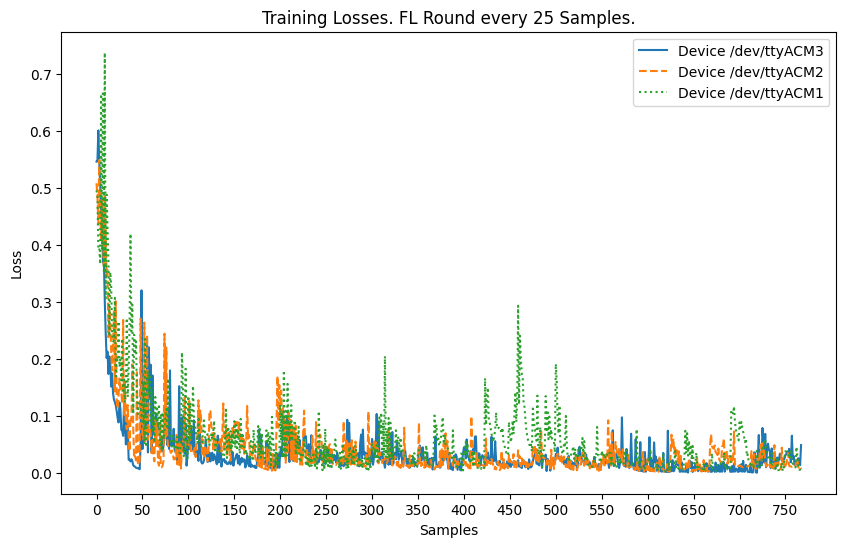

In [31]:
#from matplotlib.pyplot import *

plot(get_info(loaded_dict, 'losses'), samples=768, step=50)

In [32]:
x_losses = []
for i,x in enumerate(df_test_normalized.values):
    dt, res, loss = predict(devices[0],df_test_normalized.values[i], df_test_normalized.values[i])
    x_losses.append(loss)

in predict() X =  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.47839272e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.74125874e-04
 9.08379374e-01 4.81927711e-02 1.16279070e-02 4.40000000e-01
 3.89766267e-01 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
in predict() y =  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.47839272e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.74125874e-04
 9.08379374e-01 4.81927711e-02 1.16279070e-02 4.40000000e-01
 3.89766267e-01 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
in predict() y reshaped =  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.47839272e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 

in predict() X =  [0.         0.         0.04705882 0.07039965 0.         0.
 0.         0.03603604 0.         0.         0.         0.
 0.         0.         0.         0.06075175 0.97245242 1.
 0.03488372 0.12       0.38976627 0.54737163 0.62946585 0.
 1.        ]
in predict() y =  [0.         0.         0.04705882 0.07039965 0.         0.
 0.         0.03603604 0.         0.         0.         0.
 0.         0.         0.         0.06075175 0.97245242 1.
 0.03488372 0.12       0.38976627 0.54737163 0.62946585 0.
 1.        ]
in predict() y reshaped =  [[0.         0.         0.04705882 0.07039965 0.         0.
  0.         0.03603604 0.         0.         0.         0.
  0.         0.         0.         0.06075175 0.97245242 1.
  0.03488372 0.12       0.38976627 0.54737163 0.62946585 0.
  1.        ]]
in predict() 2
in predict() X =  [0.         0.         0.0627451  0.14783927 0.         0.
 0.         0.04804805 0.5        0.         0.         0.
 0.         1.         0.        

in predict() 2
in predict() X =  [0.         0.         0.10588235 0.07039965 0.         0.
 0.         0.08108108 0.         0.         0.         0.
 0.         1.         0.         0.06337413 0.91329036 0.22891566
 0.04651163 1.         0.44774338 0.54737163 0.62946585 0.
 0.2       ]
in predict() y =  [0.         0.         0.10588235 0.07039965 0.         0.
 0.         0.08108108 0.         0.         0.         0.
 0.         1.         0.         0.06337413 0.91329036 0.22891566
 0.04651163 1.         0.44774338 0.54737163 0.62946585 0.
 0.2       ]
in predict() y reshaped =  [[0.         0.         0.10588235 0.07039965 0.         0.
  0.         0.08108108 0.         0.         0.         0.
  0.         1.         0.         0.06337413 0.91329036 0.22891566
  0.04651163 1.         0.44774338 0.54737163 0.62946585 0.
  0.2       ]]
in predict() 2
in predict() X =  [0.         0.         0.12156863 0.14783927 0.         0.
 0.         0.09309309 0.5        0.         0.      

in predict() X =  [0.00000000e+00 0.00000000e+00 1.76470588e-01 3.24921477e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.35135135e-01
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 7.08041958e-02
 8.83210559e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
in predict() y =  [0.00000000e+00 0.00000000e+00 1.76470588e-01 3.24921477e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.35135135e-01
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 7.08041958e-02
 8.83210559e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
in predict() y reshaped =  [[0.00000000e+00 0.00000000e+00 1.76470588e-01 3.24921477e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.35135135e-01
  1.00000000e+00 0.00000000e+00 0.00000000e+00 

in predict() 2
in predict() X =  [0.         0.         0.21960784 0.07039965 0.         0.
 0.         0.16816817 0.5        0.         0.         0.
 0.         1.         0.         0.08828671 0.86072744 1.
 0.04651163 0.12       0.39755738 0.54737163 0.62946585 0.
 1.        ]
in predict() y =  [0.         0.         0.21960784 0.07039965 0.         0.
 0.         0.16816817 0.5        0.         0.         0.
 0.         1.         0.         0.08828671 0.86072744 1.
 0.04651163 0.12       0.39755738 0.54737163 0.62946585 0.
 1.        ]
in predict() y reshaped =  [[0.         0.         0.21960784 0.07039965 0.         0.
  0.         0.16816817 0.5        0.         0.         0.
  0.         1.         0.         0.08828671 0.86072744 1.
  0.04651163 0.12       0.39755738 0.54737163 0.62946585 0.
  1.        ]]
in predict() 2
in predict() X =  [0.         0.         0.23529412 0.14783927 0.         0.
 0.         0.18018018 0.         0.         0.         0.
 0.         0.    

in predict() X =  [0.         0.         0.2745098  0.07039965 0.         0.
 0.         0.21021021 0.         0.         0.         0.
 0.         1.         0.         0.09222028 0.83479128 0.40963855
 0.34883721 0.12       0.62946585 0.86958114 1.         0.
 0.2       ]
in predict() y =  [0.         0.         0.2745098  0.07039965 0.         0.
 0.         0.21021021 0.         0.         0.         0.
 0.         1.         0.         0.09222028 0.83479128 0.40963855
 0.34883721 0.12       0.62946585 0.86958114 1.         0.
 0.2       ]
in predict() y reshaped =  [[0.         0.         0.2745098  0.07039965 0.         0.
  0.         0.21021021 0.         0.         0.         0.
  0.         1.         0.         0.09222028 0.83479128 0.40963855
  0.34883721 0.12       0.62946585 0.86958114 1.         0.
  0.2       ]]
in predict() 2
in predict() X =  [0.         0.         0.29019608 0.14783927 0.         0.
 0.         0.22222222 0.         0.         0.         0.
 0.      

in predict() X =  [0.00000000e+00 0.00000000e+00 3.41176471e-01 3.24921477e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.61261261e-01
 5.00000000e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 9.79020979e-02
 8.01872314e-01 2.28915663e-01 9.30232558e-02 1.00000000e+00
 3.52144311e-01 5.47371633e-01 6.29465852e-01 0.00000000e+00
 8.00000000e-01]
in predict() y =  [0.00000000e+00 0.00000000e+00 3.41176471e-01 3.24921477e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.61261261e-01
 5.00000000e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 9.79020979e-02
 8.01872314e-01 2.28915663e-01 9.30232558e-02 1.00000000e+00
 3.52144311e-01 5.47371633e-01 6.29465852e-01 0.00000000e+00
 8.00000000e-01]
in predict() y reshaped =  [[0.00000000e+00 0.00000000e+00 3.41176471e-01 3.24921477e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.61261261e-01
  5.00000000e-01 0.00000000e+00 0.00000000e+00 

in predict() X =  [0.         0.         0.38823529 0.06108524 0.         0.
 0.         0.2972973  0.         0.         0.         0.
 0.         0.         0.         0.10751748 0.79887968 0.12048193
 0.52325581 0.12       0.62946585 0.3457084  0.39755738 0.
 0.8       ]
in predict() y =  [0.         0.         0.38823529 0.06108524 0.         0.
 0.         0.2972973  0.         0.         0.         0.
 0.         0.         0.         0.10751748 0.79887968 0.12048193
 0.52325581 0.12       0.62946585 0.3457084  0.39755738 0.
 0.8       ]
in predict() y reshaped =  [[0.         0.         0.38823529 0.06108524 0.         0.
  0.         0.2972973  0.         0.         0.         0.
  0.         0.         0.         0.10751748 0.79887968 0.12048193
  0.52325581 0.12       0.62946585 0.3457084  0.39755738 0.
  0.8       ]]
in predict() 2
in predict() X =  [0.00000000e+00 0.00000000e+00 3.96078431e-01 3.24921477e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03303303e-01
 0.00

in predict() 2
in predict() X =  [0.00000000e+00 0.00000000e+00 4.50980392e-01 3.24921477e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.45345345e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.39423077e-01
 7.74861878e-01 1.20481928e-01 6.04651163e-01 1.20000000e-01
 6.29465852e-01 4.26947433e-01 4.90980557e-01 0.00000000e+00
 1.00000000e+00]
in predict() y =  [0.00000000e+00 0.00000000e+00 4.50980392e-01 3.24921477e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.45345345e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.39423077e-01
 7.74861878e-01 1.20481928e-01 6.04651163e-01 1.20000000e-01
 6.29465852e-01 4.26947433e-01 4.90980557e-01 0.00000000e+00
 1.00000000e+00]
in predict() y reshaped =  [[0.00000000e+00 0.00000000e+00 4.50980392e-01 3.24921477e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.45345345e-01
  0.00000000e+00 0.00000000e+00 

in predict() X =  [0.         0.         0.50588235 0.14783927 0.         0.
 0.         0.38738739 0.         0.         0.         0.
 0.         0.         0.         0.18006993 0.6611418  0.22891566
 0.13953488 0.68       0.65676985 0.54737163 0.62946585 0.
 1.        ]
in predict() y =  [0.         0.         0.50588235 0.14783927 0.         0.
 0.         0.38738739 0.         0.         0.         0.
 0.         0.         0.         0.18006993 0.6611418  0.22891566
 0.13953488 0.68       0.65676985 0.54737163 0.62946585 0.
 1.        ]
in predict() y reshaped =  [[0.         0.         0.50588235 0.14783927 0.         0.
  0.         0.38738739 0.         0.         0.         0.
  0.         0.         0.         0.18006993 0.6611418  0.22891566
  0.13953488 0.68       0.65676985 0.54737163 0.62946585 0.
  1.        ]]
in predict() 2
in predict() X =  [0.         0.         0.49803922 0.06108524 0.         0.
 0.         0.38138138 0.         0.         0.         0.
 0.      

in predict() 2
in predict() X =  [0.         0.         0.55294118 0.14783927 0.         0.
 0.         0.42342342 0.5        0.         0.         0.
 0.         0.         0.         0.2111014  0.63919583 0.04819277
 0.13953488 0.44       0.44774338 1.         0.         0.
 0.        ]
in predict() y =  [0.         0.         0.55294118 0.14783927 0.         0.
 0.         0.42342342 0.5        0.         0.         0.
 0.         0.         0.         0.2111014  0.63919583 0.04819277
 0.13953488 0.44       0.44774338 1.         0.         0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.55294118 0.14783927 0.         0.
  0.         0.42342342 0.5        0.         0.         0.
  0.         0.         0.         0.2111014  0.63919583 0.04819277
  0.13953488 0.44       0.44774338 1.         0.         0.
  0.        ]]
in predict() 2
in predict() X =  [0.         0.         0.54509804 0.06108524 0.         0.
 0.         0.41741742 0.         0.         0.      

in predict() 2
in predict() X =  [0.         0.         0.58431373 0.07039965 0.         0.
 0.         0.44744745 0.         0.         0.         0.
 0.         0.         0.         0.2618007  0.70994475 0.04819277
 0.76744186 0.44       0.62946585 1.         0.         0.
 0.        ]
in predict() y =  [0.         0.         0.58431373 0.07039965 0.         0.
 0.         0.44744745 0.         0.         0.         0.
 0.         0.         0.         0.2618007  0.70994475 0.04819277
 0.76744186 0.44       0.62946585 1.         0.         0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.58431373 0.07039965 0.         0.
  0.         0.44744745 0.         0.         0.         0.
  0.         0.         0.         0.2618007  0.70994475 0.04819277
  0.76744186 0.44       0.62946585 1.         0.         0.
  0.        ]]
in predict() 2
in predict() X =  [0.         0.         0.6        0.14783927 0.         0.
 0.         0.45945946 0.         0.         0.      

in predict() 2
in predict() X =  [0.00000000e+00 0.00000000e+00 6.43137255e-01 3.24921477e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.92492492e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68444056e-01
 6.81169429e-01 4.81927711e-02 1.86046512e-01 4.40000000e-01
 3.51933740e-01 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
in predict() y =  [0.00000000e+00 0.00000000e+00 6.43137255e-01 3.24921477e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.92492492e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.68444056e-01
 6.81169429e-01 4.81927711e-02 1.86046512e-01 4.40000000e-01
 3.51933740e-01 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
in predict() y reshaped =  [[0.00000000e+00 0.00000000e+00 6.43137255e-01 3.24921477e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 4.92492492e-01
  0.00000000e+00 0.00000000e+00 

in predict() 2
in predict() X =  [0.         0.         0.2        0.21455648 0.         0.
 0.         0.15315315 1.         0.         0.         0.
 0.         1.         0.         0.08828671 0.7856814  0.
 0.         0.         0.         0.         0.         0.
 0.        ]
in predict() y =  [0.         0.         0.2        0.21455648 0.         0.
 0.         0.15315315 1.         0.         0.         0.
 0.         1.         0.         0.08828671 0.7856814  0.
 0.         0.         0.         0.         0.         0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.2        0.21455648 0.         0.
  0.         0.15315315 1.         0.         0.         0.
  0.         1.         0.         0.08828671 0.7856814  0.
  0.         0.         0.         0.         0.         0.
  0.        ]]
in predict() 2
in predict() X =  [0.00000000e+00 0.00000000e+00 6.90196078e-01 3.24921477e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.28528529e-01
 0.00000000e+0

in predict() X =  [0.         0.         0.72156863 0.07039965 0.         0.
 0.         0.55255255 0.         0.         0.         0.
 0.         0.         0.         0.42001748 0.64464395 0.04819277
 0.19767442 0.44       0.35193374 1.         0.         0.
 0.        ]
in predict() y =  [0.         0.         0.72156863 0.07039965 0.         0.
 0.         0.55255255 0.         0.         0.         0.
 0.         0.         0.         0.42001748 0.64464395 0.04819277
 0.19767442 0.44       0.35193374 1.         0.         0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.72156863 0.07039965 0.         0.
  0.         0.55255255 0.         0.         0.         0.
  0.         0.         0.         0.42001748 0.64464395 0.04819277
  0.19767442 0.44       0.35193374 1.         0.         0.
  0.        ]]
in predict() 2
in predict() X =  [0.         0.         0.7372549  0.14783927 0.         0.
 0.         0.56456456 0.         0.         0.         0.
 0.      

in predict() X =  [0.         0.         0.31764706 0.21455648 0.         0.
 0.         0.24324324 0.         0.         0.         0.
 0.         1.         0.         0.09659091 0.72682627 0.22891566
 0.09302326 1.         0.35193374 0.54737163 0.62946585 0.
 0.8       ]
in predict() y =  [0.         0.         0.31764706 0.21455648 0.         0.
 0.         0.24324324 0.         0.         0.         0.
 0.         1.         0.         0.09659091 0.72682627 0.22891566
 0.09302326 1.         0.35193374 0.54737163 0.62946585 0.
 0.8       ]
in predict() y reshaped =  [[0.         0.         0.31764706 0.21455648 0.         0.
  0.         0.24324324 0.         0.         0.         0.
  0.         1.         0.         0.09659091 0.72682627 0.22891566
  0.09302326 1.         0.35193374 0.54737163 0.62946585 0.
  0.8       ]]
in predict() 2
in predict() X =  [0.         0.         0.32156863 0.21455648 0.         0.
 0.         0.24624625 1.         0.         0.         0.
 0.      

in predict() X =  [0.         0.         0.54509804 0.21455648 0.         0.
 0.         0.41741742 0.         0.         0.         0.
 0.         0.         0.         0.18618881 0.6427256  0.12048193
 0.69767442 0.12       0.62946585 0.33893339 0.38976627 0.
 0.6       ]
in predict() y =  [0.         0.         0.54509804 0.21455648 0.         0.
 0.         0.41741742 0.         0.         0.         0.
 0.         0.         0.         0.18618881 0.6427256  0.12048193
 0.69767442 0.12       0.62946585 0.33893339 0.38976627 0.
 0.6       ]
in predict() y reshaped =  [[0.         0.         0.54509804 0.21455648 0.         0.
  0.         0.41741742 0.         0.         0.         0.
  0.         0.         0.         0.18618881 0.6427256  0.12048193
  0.69767442 0.12       0.62946585 0.33893339 0.38976627 0.
  0.6       ]]
in predict() 2
in predict() X =  [0.         0.         0.54901961 0.21455648 0.         0.
 0.         0.42042042 0.         0.         0.         0.
 0.      

in predict() X =  [0.         0.         0.02352941 0.47037799 0.         0.
 0.         0.01801802 0.         0.         0.         0.
 0.         0.         0.         0.00305944 0.89779006 0.04819277
 0.01162791 0.44       0.39755738 1.         0.         0.
 0.        ]
in predict() y =  [0.         0.         0.02352941 0.47037799 0.         0.
 0.         0.01801802 0.         0.         0.         0.
 0.         0.         0.         0.00305944 0.89779006 0.04819277
 0.01162791 0.44       0.39755738 1.         0.         0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.02352941 0.47037799 0.         0.
  0.         0.01801802 0.         0.         0.         0.
  0.         0.         0.         0.00305944 0.89779006 0.04819277
  0.01162791 0.44       0.39755738 1.         0.         0.
  0.        ]]
in predict() 2
in predict() X =  [0.         0.         0.76078431 0.21455648 0.         0.
 0.         0.58258258 0.         0.         0.         0.
 0.      

in predict() 2
in predict() X =  [0.         0.         0.17254902 0.47037799 0.         0.
 0.         0.13213213 0.         0.         0.         0.
 0.         1.         0.         0.0708042  0.79788214 0.12048193
 0.19767442 0.12       0.62946585 0.3404593  0.39152102 0.
 0.8       ]
in predict() y =  [0.         0.         0.17254902 0.47037799 0.         0.
 0.         0.13213213 0.         0.         0.         0.
 0.         1.         0.         0.0708042  0.79788214 0.12048193
 0.19767442 0.12       0.62946585 0.3404593  0.39152102 0.
 0.8       ]
in predict() y reshaped =  [[0.         0.         0.17254902 0.47037799 0.         0.
  0.         0.13213213 0.         0.         0.         0.
  0.         1.         0.         0.0708042  0.79788214 0.12048193
  0.19767442 0.12       0.62946585 0.3404593  0.39152102 0.
  0.8       ]]
in predict() 2
in predict() X =  [0.         0.         0.02745098 0.05837756 0.         0.
 0.         0.02102102 0.5        0.         0.      

in predict() 2
in predict() X =  [0.         0.         0.14117647 0.05837756 0.         0.
 0.         0.10810811 0.         0.         0.         0.
 0.         1.         0.         0.06774476 0.89617864 0.22891566
 0.05813953 1.         0.39152102 0.54737163 0.62946585 0.
 0.4       ]
in predict() y =  [0.         0.         0.14117647 0.05837756 0.         0.
 0.         0.10810811 0.         0.         0.         0.
 0.         1.         0.         0.06774476 0.89617864 0.22891566
 0.05813953 1.         0.39152102 0.54737163 0.62946585 0.
 0.4       ]
in predict() y reshaped =  [[0.         0.         0.14117647 0.05837756 0.         0.
  0.         0.10810811 0.         0.         0.         0.
  0.         1.         0.         0.06774476 0.89617864 0.22891566
  0.05813953 1.         0.39152102 0.54737163 0.62946585 0.
  0.4       ]]
in predict() 2
in predict() X =  [0.         0.         0.29019608 0.47037799 0.         0.
 0.         0.22222222 0.         0.         0.      

in predict() X =  [0.         0.         0.24705882 0.05837756 0.         0.
 0.         0.18918919 0.         0.         0.         0.
 0.         1.         0.         0.09134615 0.84445979 0.12048193
 0.29069767 0.12       0.62946585 0.3457084  0.39755738 0.
 0.        ]
in predict() y =  [0.         0.         0.24705882 0.05837756 0.         0.
 0.         0.18918919 0.         0.         0.         0.
 0.         1.         0.         0.09134615 0.84445979 0.12048193
 0.29069767 0.12       0.62946585 0.3457084  0.39755738 0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.24705882 0.05837756 0.         0.
  0.         0.18918919 0.         0.         0.         0.
  0.         1.         0.         0.09134615 0.84445979 0.12048193
  0.29069767 0.12       0.62946585 0.3457084  0.39755738 0.
  0.        ]]
in predict() 2
in predict() X =  [0.         0.         0.39607843 0.47037799 0.         0.
 0.         0.3033033  0.         0.         0.         0.
 0.      

in predict() 2
in predict() X =  [0.         0.         0.36470588 0.05837756 0.         0.
 0.         0.27927928 0.5        0.         0.         0.
 0.         1.         0.         0.10576923 0.79028545 0.04819277
 0.08139535 0.44       0.38976627 1.         0.         0.
 0.        ]
in predict() y =  [0.         0.         0.36470588 0.05837756 0.         0.
 0.         0.27927928 0.5        0.         0.         0.
 0.         1.         0.         0.10576923 0.79028545 0.04819277
 0.08139535 0.44       0.38976627 1.         0.         0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.36470588 0.05837756 0.         0.
  0.         0.27927928 0.5        0.         0.         0.
  0.         1.         0.         0.10576923 0.79028545 0.04819277
  0.08139535 0.44       0.38976627 1.         0.         0.
  0.        ]]
in predict() 2
in predict() X =  [0.         0.         0.51372549 0.47037799 0.         0.
 0.         0.39339339 1.         0.         0.      

in predict() 2
in predict() X =  [0.         0.         0.4745098  0.05837756 0.         0.
 0.         0.36336336 1.         0.         0.         0.
 0.         1.         0.         0.14947552 0.74739104 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
in predict() y =  [0.         0.         0.4745098  0.05837756 0.         0.
 0.         0.36336336 1.         0.         0.         0.
 0.         1.         0.         0.14947552 0.74739104 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.4745098  0.05837756 0.         0.
  0.         0.36336336 1.         0.         0.         0.
  0.         1.         0.         0.14947552 0.74739104 0.
  0.         0.         0.         0.         0.         0.
  0.        ]]
in predict() 2
in predict() X =  [0.         0.         0.62352941 0.47037799 0.         0.
 0.         0.47747748 0.5        0.         0.         0.
 0.         0.    

in predict() X =  [0.         0.         0.58431373 0.05837756 0.         0.
 0.         0.44744745 1.         0.         0.         0.
 0.         0.         0.         0.19318182 0.71086556 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
in predict() y =  [0.         0.         0.58431373 0.05837756 0.         0.
 0.         0.44744745 1.         0.         0.         0.
 0.         0.         0.         0.19318182 0.71086556 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.58431373 0.05837756 0.         0.
  0.         0.44744745 1.         0.         0.         0.
  0.         0.         0.         0.19318182 0.71086556 0.
  0.         0.         0.         0.         0.         0.
  0.        ]]
in predict() 2
in predict() X =  [0.         0.         0.73333333 0.47037799 0.         0.
 0.         0.56156156 0.         0.         0.         0.
 0.         0.         0.        

in predict() 2
in predict() X =  [0.         0.         0.70196078 0.05837756 0.         0.
 0.         0.53753754 0.         0.         0.         0.
 0.         0.         0.         0.37019231 0.65339165 0.04819277
 0.1627907  0.44       0.39152102 1.         0.         0.
 0.        ]
in predict() y =  [0.         0.         0.70196078 0.05837756 0.         0.
 0.         0.53753754 0.         0.         0.         0.
 0.         0.         0.         0.37019231 0.65339165 0.04819277
 0.1627907  0.44       0.39152102 1.         0.         0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.70196078 0.05837756 0.         0.
  0.         0.53753754 0.         0.         0.         0.
  0.         0.         0.         0.37019231 0.65339165 0.04819277
  0.1627907  0.44       0.39152102 1.         0.         0.
  0.        ]]
in predict() 2
in predict() X =  [0.         0.         0.70588235 0.05837756 0.         0.
 0.         0.54054054 0.         0.         0.      

in predict() X =  [0.         0.         0.04313725 0.         0.         0.
 0.         0.03303303 0.         0.         0.         0.
 0.         0.         0.         0.0541958  0.98020258 0.04819277
 0.02325581 0.44       0.39152102 1.         0.         0.
 0.        ]
in predict() y =  [0.         0.         0.04313725 0.         0.         0.
 0.         0.03303303 0.         0.         0.         0.
 0.         0.         0.         0.0541958  0.98020258 0.04819277
 0.02325581 0.44       0.39152102 1.         0.         0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.04313725 0.         0.         0.
  0.         0.03303303 0.         0.         0.         0.
  0.         0.         0.         0.0541958  0.98020258 0.04819277
  0.02325581 0.44       0.39152102 1.         0.         0.
  0.        ]]
in predict() 2
in predict() X =  [0.         0.         0.04705882 0.         0.         0.
 0.         0.03603604 0.         0.         0.         0.
 0.      

in predict() X =  [0.         0.         0.27843137 0.         0.         0.
 0.         0.21321321 0.         0.         0.         0.
 0.         1.         0.         0.09353147 0.83816759 0.12048193
 0.36046512 0.12       0.62946585 0.30603494 0.35193374 0.
 0.4       ]
in predict() y =  [0.         0.         0.27843137 0.         0.         0.
 0.         0.21321321 0.         0.         0.         0.
 0.         1.         0.         0.09353147 0.83816759 0.12048193
 0.36046512 0.12       0.62946585 0.30603494 0.35193374 0.
 0.4       ]
in predict() y reshaped =  [[0.         0.         0.27843137 0.         0.         0.
  0.         0.21321321 0.         0.         0.         0.
  0.         1.         0.         0.09353147 0.83816759 0.12048193
  0.36046512 0.12       0.62946585 0.30603494 0.35193374 0.
  0.4       ]]
in predict() 2
in predict() X =  [0.         0.         0.28235294 0.         0.         0.
 0.         0.21621622 0.5        0.         0.         0.
 0.      

in predict() X =  [0.         0.         0.04313725 1.         0.         0.
 0.         0.03303303 0.         0.         0.         0.
 0.         0.         0.         0.05375874 0.88612646 0.04819277
 0.02325581 0.44       0.44774338 1.         0.         0.
 0.        ]
in predict() y =  [0.         0.         0.04313725 1.         0.         0.
 0.         0.03303303 0.         0.         0.         0.
 0.         0.         0.         0.05375874 0.88612646 0.04819277
 0.02325581 0.44       0.44774338 1.         0.         0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.04313725 1.         0.         0.
  0.         0.03303303 0.         0.         0.         0.
  0.         0.         0.         0.05375874 0.88612646 0.04819277
  0.02325581 0.44       0.44774338 1.         0.         0.
  0.        ]]
in predict() 2
in predict() X =  [0.         0.         0.45490196 0.         0.         0.
 0.         0.34834835 0.         0.         0.         0.
 0.      

in predict() X =  [0.         0.         0.55686275 0.         0.         0.
 0.         0.42642643 0.         0.         0.         0.
 0.         1.         0.         0.18487762 0.71293738 0.40963855
 0.68604651 0.12       0.62946585 0.33893339 0.38976627 0.
 0.6       ]
in predict() y =  [0.         0.         0.55686275 0.         0.         0.
 0.         0.42642643 0.         0.         0.         0.
 0.         1.         0.         0.18487762 0.71293738 0.40963855
 0.68604651 0.12       0.62946585 0.33893339 0.38976627 0.
 0.6       ]
in predict() y reshaped =  [[0.         0.         0.55686275 0.         0.         0.
  0.         0.42642643 0.         0.         0.         0.
  0.         1.         0.         0.18487762 0.71293738 0.40963855
  0.68604651 0.12       0.62946585 0.33893339 0.38976627 0.
  0.6       ]]
in predict() 2
in predict() X =  [0.         0.         0.14901961 1.         0.         0.
 0.         0.11411411 0.         0.         0.         0.
 0.      

in predict() 2
in predict() X =  [0.         0.         0.2627451  1.         0.         0.
 0.         0.2012012  0.         0.         0.         0.
 0.         1.         0.         0.09265734 0.75168815 0.22891566
 0.06976744 1.         0.39755738 0.54737163 0.62946585 0.
 0.4       ]
in predict() y =  [0.         0.         0.2627451  1.         0.         0.
 0.         0.2012012  0.         0.         0.         0.
 0.         1.         0.         0.09265734 0.75168815 0.22891566
 0.06976744 1.         0.39755738 0.54737163 0.62946585 0.
 0.4       ]
in predict() y reshaped =  [[0.         0.         0.2627451  1.         0.         0.
  0.         0.2012012  0.         0.         0.         0.
  0.         1.         0.         0.09265734 0.75168815 0.22891566
  0.06976744 1.         0.39755738 0.54737163 0.62946585 0.
  0.4       ]]
in predict() 2
in predict() X =  [0.         0.         0.6745098  0.         0.         0.
 0.         0.51651652 0.         0.         0.      

in predict() X =  [0.         0.         0.78823529 0.         0.         0.
 0.         0.6036036  0.         0.         0.         0.
 0.         0.         0.         0.36975524 0.61840086 0.04819277
 0.1744186  0.44       0.39755738 1.         0.         0.
 0.        ]
in predict() y =  [0.         0.         0.78823529 0.         0.         0.
 0.         0.6036036  0.         0.         0.         0.
 0.         0.         0.         0.36975524 0.61840086 0.04819277
 0.1744186  0.44       0.39755738 1.         0.         0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.78823529 0.         0.         0.
  0.         0.6036036  0.         0.         0.         0.
  0.         0.         0.         0.36975524 0.61840086 0.04819277
  0.1744186  0.44       0.39755738 1.         0.         0.
  0.        ]]
in predict() 2
in predict() X =  [0.         0.         0.38039216 1.         0.         0.
 0.         0.29129129 0.         0.         0.         0.
 0.      

in predict() X =  [0.         0.         0.89803922 0.         0.         0.
 0.         0.68768769 0.         0.         0.         0.
 0.         0.         0.         0.47421329 0.56606814 0.04819277
 0.19767442 0.44       0.39755738 1.         0.         0.
 0.        ]
in predict() y =  [0.         0.         0.89803922 0.         0.         0.
 0.         0.68768769 0.         0.         0.         0.
 0.         0.         0.         0.47421329 0.56606814 0.04819277
 0.19767442 0.44       0.39755738 1.         0.         0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.89803922 0.         0.         0.
  0.         0.68768769 0.         0.         0.         0.
  0.         0.         0.         0.47421329 0.56606814 0.04819277
  0.19767442 0.44       0.39755738 1.         0.         0.
  0.        ]]
in predict() 2
in predict() X =  [0.         0.         0.49019608 1.         0.         0.
 0.         0.37537538 0.         0.         0.         0.
 0.      

in predict() 2
in predict() X =  [0.         0.         0.6        1.         0.         0.
 0.         0.45945946 0.         0.         0.         0.
 0.         1.         0.         0.2111014  0.59714549 0.04819277
 0.13953488 0.44       0.44774338 1.         0.         0.
 0.        ]
in predict() y =  [0.         0.         0.6        1.         0.         0.
 0.         0.45945946 0.         0.         0.         0.
 0.         1.         0.         0.2111014  0.59714549 0.04819277
 0.13953488 0.44       0.44774338 1.         0.         0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.6        1.         0.         0.
  0.         0.45945946 0.         0.         0.         0.
  0.         1.         0.         0.2111014  0.59714549 0.04819277
  0.13953488 0.44       0.44774338 1.         0.         0.
  0.        ]]
in predict() 2
in predict() X =  [0.         0.         0.00784314 0.         0.         0.
 0.         0.77477477 0.         0.         0.      

in predict() 2
in predict() X =  [0.         0.         0.78431373 1.         0.         0.
 0.         0.6006006  0.         0.         0.         0.
 0.         1.         0.         0.38592657 0.51296808 0.40963855
 0.80232558 0.12       0.62946585 0.30603494 0.35193374 0.
 1.        ]
in predict() y =  [0.         0.         0.78431373 1.         0.         0.
 0.         0.6006006  0.         0.         0.         0.
 0.         1.         0.         0.38592657 0.51296808 0.40963855
 0.80232558 0.12       0.62946585 0.30603494 0.35193374 0.
 1.        ]
in predict() y reshaped =  [[0.         0.         0.78431373 1.         0.         0.
  0.         0.6006006  0.         0.         0.         0.
  0.         1.         0.         0.38592657 0.51296808 0.40963855
  0.80232558 0.12       0.62946585 0.30603494 0.35193374 0.
  1.        ]]
in predict() 2
in predict() X =  [0.         0.         0.78823529 1.         0.         0.
 0.         0.6036036  0.         0.         0.      

in predict() X =  [0.         0.         0.00784314 1.         0.         0.
 0.         0.77477477 0.         0.         0.         0.
 0.         0.         0.         0.73513986 0.41958257 0.04819277
 0.94186047 0.44       0.62946585 1.         0.         0.
 0.        ]
in predict() y =  [0.         0.         0.00784314 1.         0.         0.
 0.         0.77477477 0.         0.         0.         0.
 0.         0.         0.         0.73513986 0.41958257 0.04819277
 0.94186047 0.44       0.62946585 1.         0.         0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.00784314 1.         0.         0.
  0.         0.77477477 0.         0.         0.         0.
  0.         0.         0.         0.73513986 0.41958257 0.04819277
  0.94186047 0.44       0.62946585 1.         0.         0.
  0.        ]]
in predict() 2
in predict() X =  [0.         0.         0.01176471 1.         0.         0.
 0.         0.77777778 0.5        0.         0.         0.
 0.      

in predict() X =  [0.         0.         0.19607843 0.42824651 0.         0.
 0.         0.15015015 0.         0.         0.         0.
 0.85714286 0.         0.         0.08129371 0.52908226 0.22891566
 0.10465116 0.68       0.44774338 0.54737163 0.62946585 0.
 1.        ]
in predict() y =  [0.         0.         0.19607843 0.42824651 0.         0.
 0.         0.15015015 0.         0.         0.         0.
 0.85714286 0.         0.         0.08129371 0.52908226 0.22891566
 0.10465116 0.68       0.44774338 0.54737163 0.62946585 0.
 1.        ]
in predict() y reshaped =  [[0.         0.         0.19607843 0.42824651 0.         0.
  0.         0.15015015 0.         0.         0.         0.
  0.85714286 0.         0.         0.08129371 0.52908226 0.22891566
  0.10465116 0.68       0.44774338 0.54737163 0.62946585 0.
  1.        ]]
in predict() 2
in predict() X =  [0.         0.         0.2        0.42824651 0.         0.
 0.         0.15315315 0.5        0.         0.         0.
 0.857142

in predict() X =  [0.         0.         0.42352941 0.42824651 0.         0.
 0.         0.32432432 1.         0.         0.         0.
 0.57142857 0.         0.         0.12412587 0.40953039 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
in predict() y =  [0.         0.         0.42352941 0.42824651 0.         0.
 0.         0.32432432 1.         0.         0.         0.
 0.57142857 0.         0.         0.12412587 0.40953039 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.42352941 0.42824651 0.         0.
  0.         0.32432432 1.         0.         0.         0.
  0.57142857 0.         0.         0.12412587 0.40953039 0.
  0.         0.         0.         0.         0.         0.
  0.        ]]
in predict() 2
in predict() X =  [0.         0.         0.42745098 0.42824651 0.         0.
 0.         0.32732733 1.         0.         0.         0.
 0.57142857 0.         0.        

in predict() 2
in predict() X =  [0.         0.         0.6627451  0.42824651 0.         0.
 0.         0.50750751 1.         0.         0.         0.
 0.28571429 0.         0.         0.26398601 0.297345   0.
 0.         0.         0.         0.         0.         0.
 0.        ]
in predict() y =  [0.         0.         0.6627451  0.42824651 0.         0.
 0.         0.50750751 1.         0.         0.         0.
 0.28571429 0.         0.         0.26398601 0.297345   0.
 0.         0.         0.         0.         0.         0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.6627451  0.42824651 0.         0.
  0.         0.50750751 1.         0.         0.         0.
  0.28571429 0.         0.         0.26398601 0.297345   0.
  0.         0.         0.         0.         0.         0.
  0.        ]]
in predict() 2
in predict() X =  [0.         0.         0.66666667 0.42824651 0.         0.
 0.         0.51051051 0.         0.         0.         0.
 0.28571429 0.    

in predict() X =  [0.         0.         0.89803922 0.42824651 0.         0.
 0.         0.68768769 1.         0.         0.         0.
 0.14285714 0.         0.         0.43006993 0.18822897 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
in predict() y =  [0.         0.         0.89803922 0.42824651 0.         0.
 0.         0.68768769 1.         0.         0.         0.
 0.14285714 0.         0.         0.43006993 0.18822897 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.89803922 0.42824651 0.         0.
  0.         0.68768769 1.         0.         0.         0.
  0.14285714 0.         0.         0.43006993 0.18822897 0.
  0.         0.         0.         0.         0.         0.
  0.        ]]
in predict() 2
in predict() X =  [0.         0.         0.90196078 0.42824651 0.         0.
 0.         0.69069069 1.         0.         0.         0.
 0.14285714 0.         0.        

in predict() X =  [0.         0.         0.12941176 0.42824651 0.         0.
 0.         0.86786787 0.         0.         0.         0.
 0.         0.         0.         0.68487762 0.08763045 0.04819277
 0.23255814 0.44       0.39152102 1.         0.         0.
 0.        ]
in predict() y =  [0.         0.         0.12941176 0.42824651 0.         0.
 0.         0.86786787 0.         0.         0.         0.
 0.         0.         0.         0.68487762 0.08763045 0.04819277
 0.23255814 0.44       0.39152102 1.         0.         0.
 0.        ]
in predict() y reshaped =  [[0.         0.         0.12941176 0.42824651 0.         0.
  0.         0.86786787 0.         0.         0.         0.
  0.         0.         0.         0.68487762 0.08763045 0.04819277
  0.23255814 0.44       0.39152102 1.         0.         0.
  0.        ]]
in predict() 2
in predict() X =  [0.         0.         0.13333333 0.42824651 0.         0.
 0.         0.87087087 0.         0.         0.         0.
 0.      

In [24]:
r = pd.DataFrame(x_losses)
r.columns = ['loss']
y_df = pd.DataFrame(y)
y_anomalies_df = pd.DataFrame(y_anomalies)

ys = pd.concat([y_df, y_anomalies_df])
ys['loss'] = r['loss']

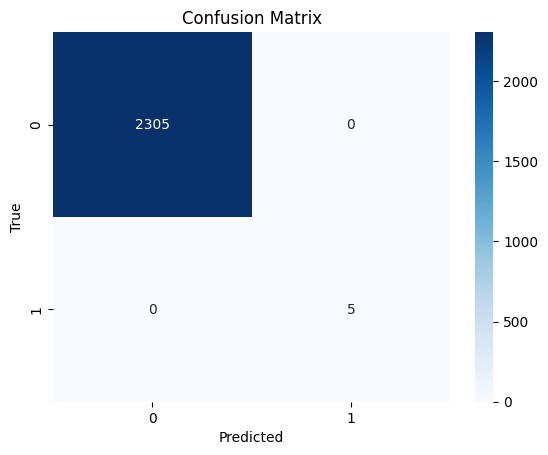

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

# Set a threshold to classify data as normal or anomalous
threshold = 1.3
y_pred = [1 if error > threshold else 0 for error in r['loss']]
# Compute evaluation metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming 'ys' is a DataFrame or Series containing the ground truth labels ('anomaly')
# Assuming 'y_pred' is a list, DataFrame, or Series containing the predicted labels

# Calculate evaluation metrics
accuracy = accuracy_score(ys['anomaly'], y_pred)
precision = precision_score(ys['anomaly'], y_pred)
recall = recall_score(ys['anomaly'], y_pred)
f1 = f1_score(ys['anomaly'], y_pred)

# Create a confusion matrix
cm = confusion_matrix(ys['anomaly'], y_pred, labels=[0, 1])

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")